# Machine Learning in Python - Project 1

Due Friday, March 8th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

We begin by loading in all necessary packages, reading in the data, and defining helper functions.

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np
# !pip install statsmodels INSTALL
import statsmodels.api as sm
# !pip install openpyxl
import openpyxl
from scipy import stats
#!pip install mlxtend

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.color_palette("hls", 12)

# Dataframe embellishment defaults
    # Formatting of index column as italics with grey font.
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}

    # Formatting of headers with blue tone used in document palette.
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #586b7a; color: white;'
}  

# sklearn modules
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
# from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
# from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.inspection import permutation_importance
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
# from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs




/tmp/ipykernel_23410/1486010762.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load data in easyshare.csv
df = pd.read_csv("easyshare.csv")

In [3]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])


def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return Metrics

# Introduction

The world's population distribution is shifting towards the predominance of ageing people, following continuous years of scientific developments that have positively impacted human beings' life expectancy. In 2018, the number of people in the world aged 65 or above surpassed people under 5 years old for the first time in history<sup>1</sup>. Moreover, by 2030, 1 out of 6 people are expected to be 60 or above and the number of people aged 80 or above are expected to triple by 2050 -versus 2020-<sup>2</sup>. These statistics reflect an ageing world population, as is consistent with the observed trend in life expectancy, which was recorded at around 73 years old for 2023, representing a gain of 10 years of life for the world's average person today versus 40 years ago.

Although these demographic figures have an encouraging flavour for humankind, the progression of the average human lifetime in years does not come without a cost. One of the adversities raised by this overall positive scenario for humanity is the prevalence of costly age-related diseases, like dementia. According to the World Health Organisation (WHO), currently over 55 million people live with dementia and this number is expected to almost triple by 2050<sup>3</sup>. In 2020, the annual cost of dementia was estimated at a staggering figure of US$818 billion and is expected to reach US$2 trillion by 2030, mostly due to familiar and social costs (not strictly medical care)<sup>4</sup>.

Fortunately, these projections are not unavoidable. As previous studies have shown (Livingstone et al. (2017), Livingstone et al. (2020), GBD 2016 Dementia Collaborators (2016)), there are over nine modifiable risks for dementia, which include less education, smoking, obesity, physical inactivity, low social contact, excessive alcohol consumption, among others. For this reason, the European Union seeks to better understand how these factors' impact on dementia severity, as this is key to develop prevention policies at a country, regional and worldwide level to reduce the social costs of this disease. 

In that regard, the purpose of this study is to adequately estimate the relationship between dementia severity and diverse demographic and health factors adding to the current academic literature on the subject, and from this estimation suggest policy areas that may be wise to focus by both the European Union and other governmental and non-governmental institutions. For this objective, we use the easySHARE data which is a simplified dataset of the panel data generated from the distinct waves (surveys in time) of the Survey of Health, Ageing and Retirement in Europe (SHARE). This dataset aims to provide data on European individuals as they age and their environment. The easySHARE database to use contains 22 variables, with observations recorded at a individual level, with one observation per individual (although different observations may correspond to different waves of SHARE).

This study will explore supervised machine learning methods, focusing specifically on estimating a regression model for easySHARE individuals' cognitive score, which will be used as a proxy variable for dementia severity, using modifiable risk factors identified by previous literature and exploring new posible factors of interest.

*“This paper uses data from the generated easySHARE data set (DOI: 10.6103/SHARE.easy.800), see Gruber et al. (2014) for methodological details. The easySHARE release 8.0.0 is based on SHARE Waves 1, 2, 3 (SHARELIFE), 4, 5, 6, 7 and 8 (DOIs: 10.6103/SHARE.w1.800, 10.6103/SHARE.w2.800, 10.6103/SHARE.w3.800, 10.6103/SHARE.w4.800,10.6103/SHARE.w5.800, 10.6103/SHARE.w6.800, 10.6103/SHARE.w7.800, 10.6103/SHARE.w8.800)”*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*If you decide to extract additional features from the full data (easyshare_all.csv), describe these variables here.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

Before modelling dementia severity (proxied by cognitive score, as mentioned in the study's introduction), we proceed to explore the easySHARE database to better understand the features we have available for our task.

In [4]:
# Visualize numerical columns in data
descr_stats = df.describe(include = [np.number]).round(2)
s = descr_stats.style.format('{:.0f}')

# Apply formatting to descriptive table
print(f'The easySHARE database contains {df.shape[0]} obsrvations of {df.shape[1]} variables.')
s.set_table_styles([index_names, headers])

The easySHARE database contains 98348 obsrvations of 23 variables.


,int_year,wave,country,country_mod,female,age,birth_country,citizenship,isced1997_r,eduyears_mod,eurod,bmi,bmi2,smoking,ever_smoked,br010_mod,br015_,casp,chronic_mod,sp008_,ch001_,cogscore
count,97372,97372,97372,97372,97372,97372,97170,97281,97372,84532,95838,94686,94686,96887,97116,79210,97113,84065,97283,83175,96928,97372
mean,2010,4,24,385,1,68,398,392,3,10,3,27,3,4,3,3,3,37,1,4,2,12
std,5,2,12,229,0,9,238,233,1,4,2,5,1,1,2,2,1,6,1,2,1,4
min,2004,1,11,40,0,55,2,4,0,0,0,13,1,1,1,1,1,12,0,1,0,0
25%,2006,2,15,208,0,60,208,208,1,8,1,24,2,5,1,1,1,32,0,1,1,9
50%,2011,4,20,300,1,67,348,348,3,11,2,26,3,5,5,3,3,37,1,5,2,12
75%,2013,5,31,616,1,74,642,620,3,13,4,29,3,5,5,5,4,42,2,5,3,15
max,2020,8,63,756,1,112,1101,1132,6,30,12,87,4,5,5,7,4,48,9,5,17,26


As presented in the table above, the easySHARE database includes 23 variables, which describe the following data:
- *mergeid*: person identifier
- *wave*: wave identifier
- *country*: country identifier
- *country_mod*: modified country identifier
- *female*: dummy encoded gender with 0 for male and 1 for female
- *age*: age at interview
- *birth_country*: country of birth
- *citizenship*: citizenship of respondent
- *isced1997_r*: ISCED-97 encoding of education (6 levels - see pg. 11 of data guide)
- *eduyears_mod*: years of education
- *eurod*: depression scale ranging from 0 “not depressed” to 12 “very depressed”
- *bmi*: body mass index
- *bmi2*: categorized body mass index
- *smoking*: smoke at present time
- *ever_smoked*: ever smoked daily
- *br010_mod*: drinking behavior
- *br015_*: vigorous activities
- *casp*: CASP-12 score measures quality of life and is based on four subscales on control,
autonomy, pleasure and self-realization, ranges from 12 to 48
- *chronic_mod*: number of chronic diseases
- *sp008_*: gives help to others outside the household
- *ch001_*: number of children
- *cogscore*: measure of cognitive function combining results from two numeracy tests, two
word recall tests, and an orientation test.

From the start, it is evident that the variables on easySHARE have different counts, which is due to the remark by SHARE that not all variables were collected in every wave. Moreover, smaller differences in the counts of variables could be due to individuals not answering some of the questions in the survey.

We also identify that some categorical variables in the database have been coded in an ordinal manner, while the steps between each category may not necessarily have the same contribution to dementia severity (i.e. the effect of an inidividual going from underweight to normal weight in the variable *bmi2* would likely be significantly different on the cognitive score of this person than the effect if they go from overweight to obese.). This is something we will likely have to explore as possible alternatives in the modelling section of this study.

Finally, from this descriptive table we can see that some of our continuous variables start at zero, which may pose challenges if we need to perform Box-Cox transformations as part of our feature engineering<sup>5</sup>. 

Text(0.5, 1.015, 'Histograms of Non-ID Variables in easySHARE')

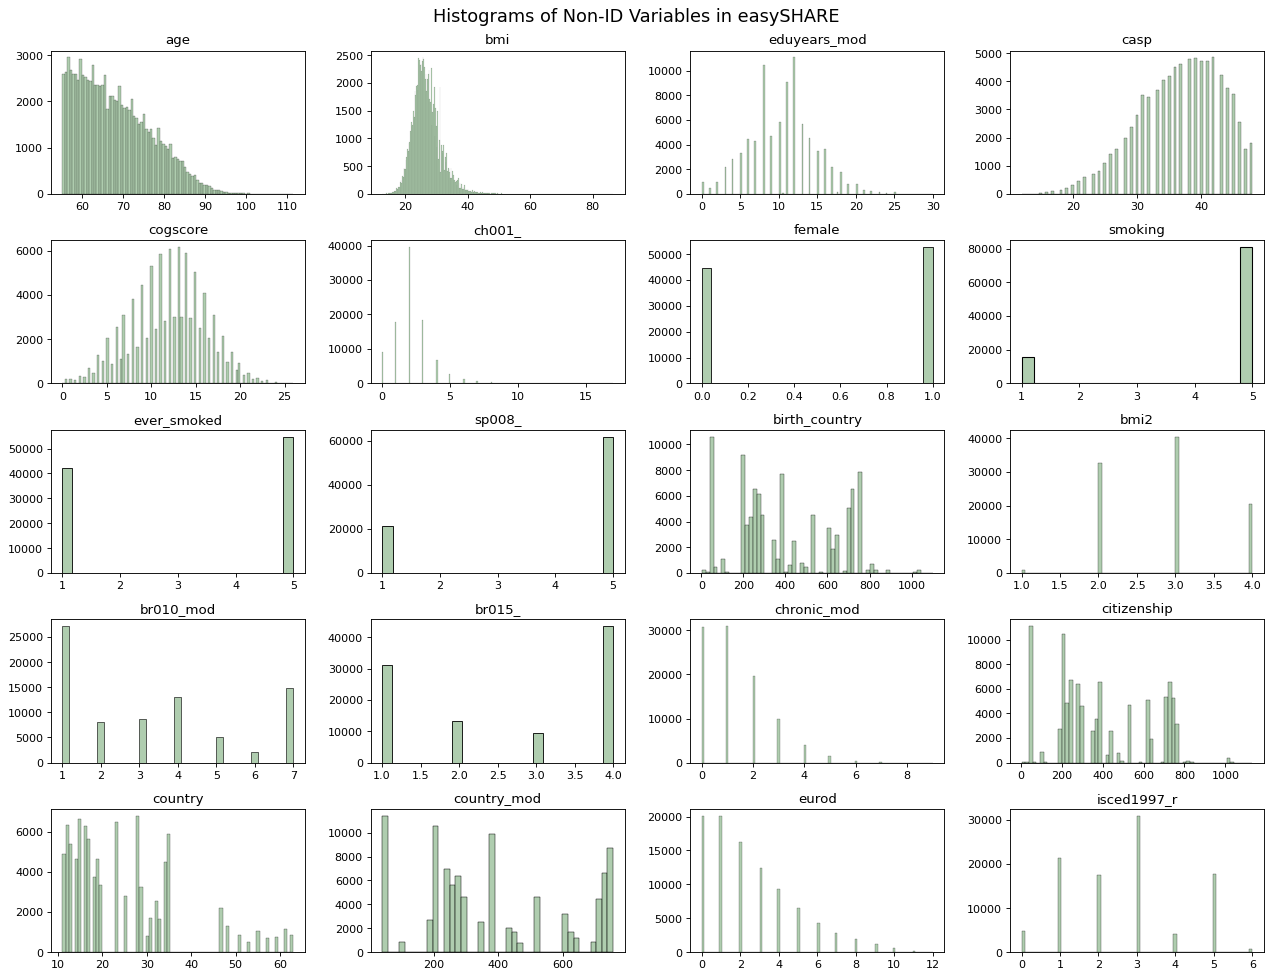

In [5]:
# Initial Data Exploration
#df.info()

    ## There are no missing values (unanswered, etc) according to the codes listed 
    ## in the data description file.

# List of columns per type of variable
id_vars = ['int_year','wave','mergeid']     # ID variables
numerical_vars = ['age','bmi','eduyears_mod','casp','cogscore','ch001_']     # Non-categorical variables
binary_vars = ['female','smoking','ever_smoked','sp008_']     # Binary variables
cat_vars = np.setdiff1d(df.columns,id_vars + numerical_vars + binary_vars).tolist()     # Categorical variables (n>2)

#len(cat_vars+binary_vars+numerical_vars+id_vars)==len(df.columns) # Checking no variables are missing

# Explore variable distributions through histograms
non_id_vars = numerical_vars + binary_vars + cat_vars # Get vector of all variables to plot with histograms
#len(non_id_vars)                            # 20 variables are non_id

# Figure plot area and settings
fig, ax = plt.subplots(figsize = (16, 12))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# For-loop to create histograms
for n, col in enumerate(non_id_vars):
    plt.subplot(5, 4, n+1)
    a = sns.histplot(df[col],ax = plt.gca(),color='#95bd95')
    a.set(xlabel=None, ylabel=None)
    a.set_facecolor('white')
    plt.title(col)

plt.tight_layout()
plt.suptitle("Histograms of Non-ID Variables in easySHARE", fontsize=16,y=1.015)


Apparent in the histograms above, the features in easySHARE follow a variety of distributions. Specifically, most do not present a normal -or similar- distribution. Some of the histograms are heavy-tailed, meaning their tails hold more weight than a normal, or they are skewed, meaning they extend farther to the right of the median than to the left (or vice versa). This may make it harder for some algorithms to detect patterns. These characteristics suggest we should consider normalising the data by performing Box-Cox transformations.

Nonetheless, it is worth mentioning that a good proportion of our available features are skewed count or categorical variables (some of which have significant density at value 0, as is the case with *eurod* and *chronic_mod*). Adequately managing these features' characteristics requires some additional subtlety, especially when handling their outliers and transforming them to more normal-like distributions to be able to do inference with their coefficients in the models.

To better understand the peculiarities of the variables in our dataset and which transformations may be necessary prior to the modelling stage, we will proceed to explore the boxplots of the available features.


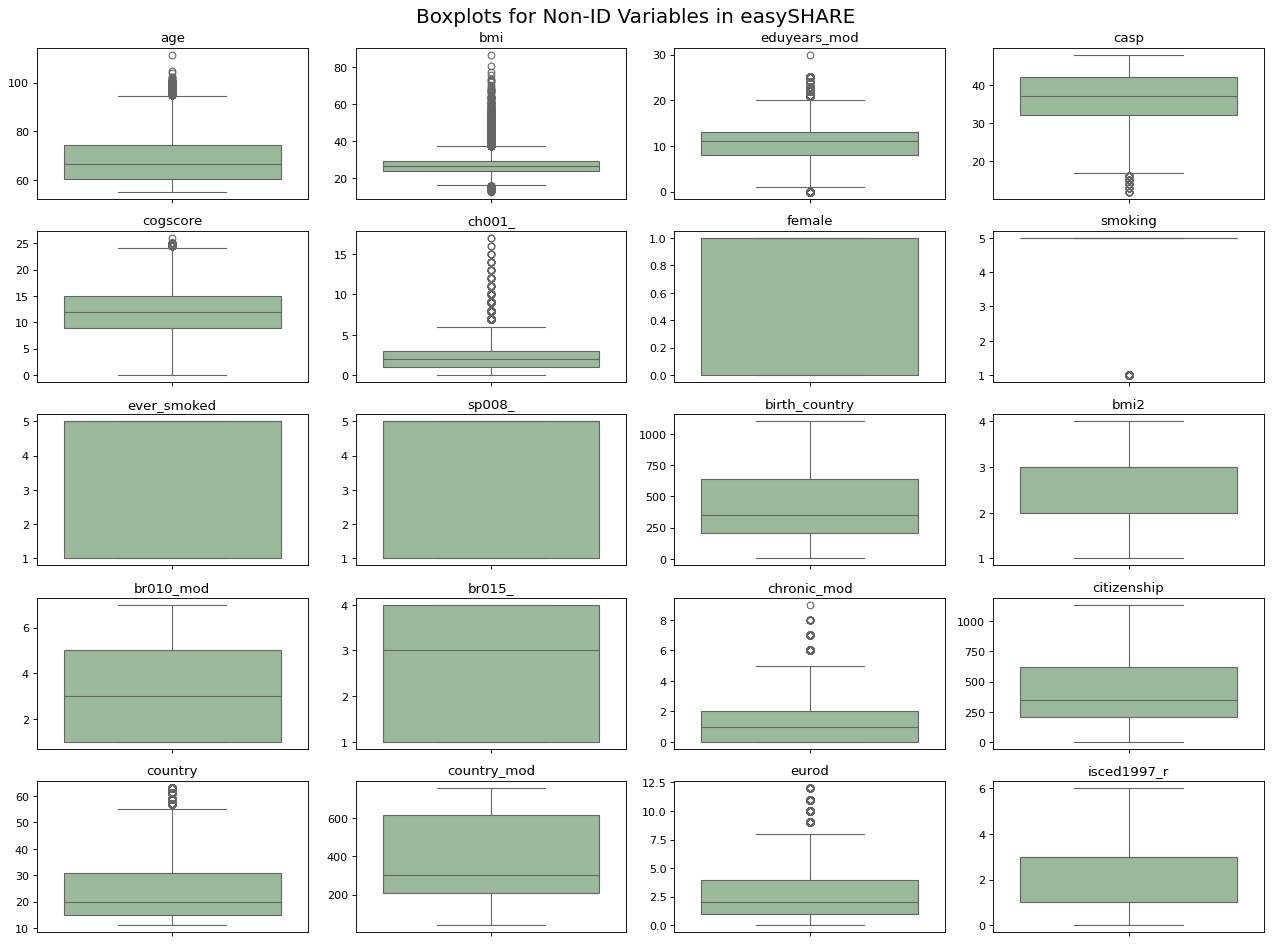

In [6]:
# Generating Box-Plots for Non-ID Variables
fig, axes = plt.subplots(figsize = (16, 12), ncols = 4, nrows=5, sharex = True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(y = df[non_id_vars].values[:,i], ax = ax,color='#95bd95') 
    ax.set_title(non_id_vars[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots for Non-ID Variables in easySHARE", fontsize=18)
plt.tight_layout()

As stated above, some of the dataset's features have a significant number of outliers. It is worth differentiating the outlier treatment we suggest for these variables:

- *age*: Given we want to estimate dementia severity, which is tightly linked to age, removing the outliers for this variable would be detrimental to the data, because it would reduce the capacity of our model to estimate dementia severity for people in higher percentiles of age which is where dementia is more prevelant.

- *bmi*: This variable appears to have a significant number of outliers, however all of which are important data points.  We cannot discount these points in favour of a nicer distribution to work with.  Instead, its categorical transformation *bmi2* will be used.  It has a more intuitive interpretation in a prediction model.

- *eurod*: This variable is a categorical feature that represents how depressed the surveyed individual is. Thus, removing its outliers would remove the more extreme categories (i.e.: 12 stands for 'very depressed') and therefore reduce the capacity of our model to estimate dementia severity for people most affected by depression.

- *casp*: The outliers in this variable, which is an index representing quality of life, are found in the lower-end of its distribution. These points would be associated to a higher risk of high dementia severity. For this reason, similar to the logic used for the previous variable, we decide to keep the outliers.

- *eduyears_mod*, *ch001_* and *chronic_mod*: Given these variables are counts (education years, number of children and number of chronic diseases) whose extremes may not be as useful to distinguish from its upper values (i.e.: Someone with a PhD education would most likely have a similar dementia severity prediction based on this feature alone that someone with a post-Doctoral degree), we suggest handling these outliers through winsorization, as is suggested for skewed counts<sup>6</sup>.

Now, we will proceed to clean our data and explore if winsorization does indeed improve the outliers in these distributions.

In [7]:
# Data Cleaning

# Creating a copy of dataframe where all data cleaning and transformations will be stored
df_transformations = df.copy()

# Drop the null values
df_transformations = df_transformations.dropna()

# We have no duplicated values :)
#df_transformations.duplicated().sum()

# Check null values per column
#df_transformations.isna().sum(axis = 0)

In [8]:
# Winsorizing eduyears_mod, chronic_mod and ch001_
# Finding the 99th (upper bound) and 1st (lower bound) percentiles for each variable to winsorize

# Bounds for years of education
upper_lim_edu = df['eduyears_mod'].quantile(0.99)
lower_lim_edu = df['eduyears_mod'].quantile(0.01)

# Bounds for chronic diseases    
upper_lim_chr = df['chronic_mod'].quantile(0.99)
lower_lim_chr = df['chronic_mod'].quantile(0.01)

# Bounds for number of children
upper_lim_child = df['ch001_'].quantile(0.99)
lower_lim_child = df['ch001_'].quantile(0.01)

# Replacing original variables with winsorized vectors
df_transformations['eduyears_mod'] = np.where(df_transformations['eduyears_mod'] >= upper_lim_edu,
                        upper_lim_edu,
                        np.where(df_transformations['eduyears_mod'] <= lower_lim_edu,
                        lower_lim_edu,
                        df_transformations['eduyears_mod']))

df_transformations['chronic_mod'] = np.where(df_transformations['chronic_mod'] >= upper_lim_chr,
                        upper_lim_chr,
                        np.where(df_transformations['chronic_mod'] <= lower_lim_chr,
                        lower_lim_chr,
                        df_transformations['chronic_mod']))

df_transformations['ch001_'] = np.where(df_transformations['ch001_'] >= upper_lim_child,
                        upper_lim_child,
                        np.where(df_transformations['ch001_'] <= lower_lim_child,
                        lower_lim_child,
                        df_transformations['ch001_']))


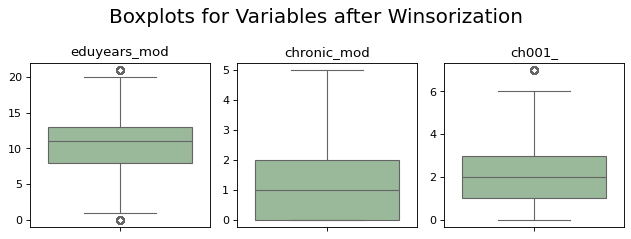

In [9]:
# Generating boxplots after winsorization

# Vector of variables that were winsorized
winsor_vars = ['eduyears_mod','chronic_mod','ch001_']

fig, axes = plt.subplots(figsize = (8, 3), ncols = 3, nrows=1, sharex = True)
axes = axes.flatten()
winsor_vars_values = df_transformations[winsor_vars].values

for i, ax in enumerate(axes):
    sns.boxplot(y = winsor_vars_values[:,i], ax = ax, color='#95bd95') 
    ax.set_title(winsor_vars[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots for Variables after Winsorization", fontsize=18)
plt.tight_layout()


Indeed, winsorizing *eduyears_mod*, *chronic_mod* and *ch001_* with their 99th and 1st percentiles as bounds helped to regularize the outliers for these features. 

We will now explore the normality for the standardized version of the numerical features (count and continuous variables) in our dataset.

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 0.98, 'Q-Q Plots of Numerical Variables in easySHARE')

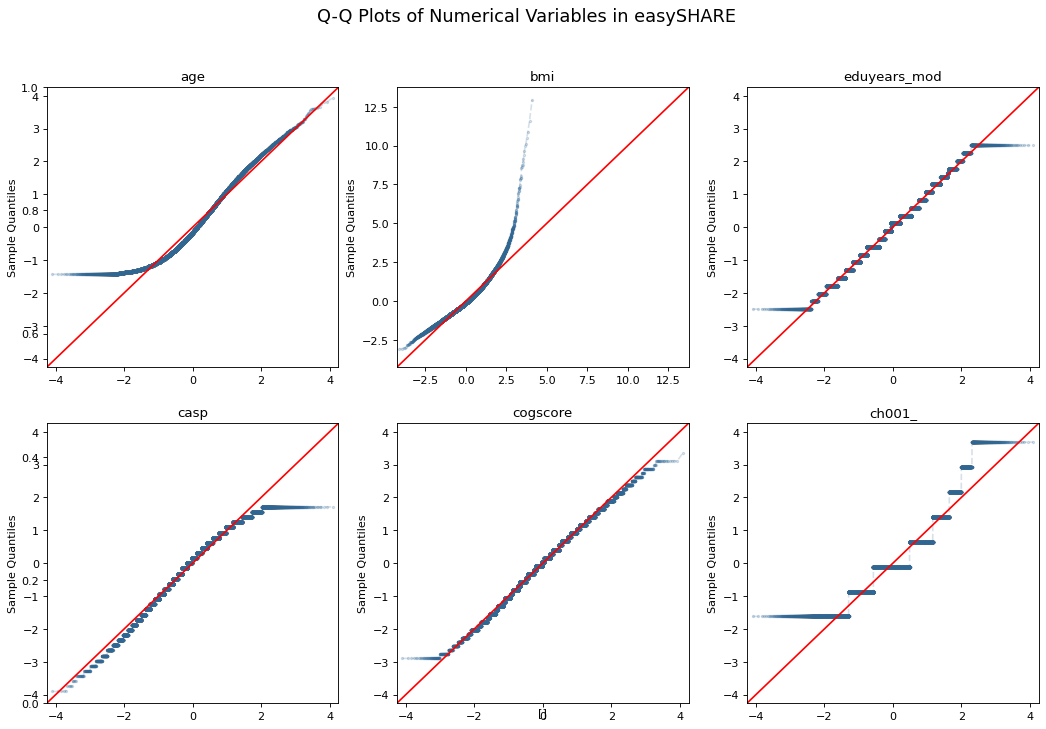

In [10]:
# Q-Q Plot Exploration of Normality for Numerical Variables 
# in easySHARE

# Standardization of the Numerical Variables in easySHARE
std_numerical_df = df_transformations[numerical_vars].values #returns a numpy array
std_numerical_df = pp.StandardScaler().fit_transform(std_numerical_df)
std_numerical_df = pd.DataFrame(std_numerical_df, columns=numerical_vars)

fig, axs = plt.subplots(figsize=(16, 10))
axs.set_frame_on(False)
axs.set_xticks([])
axs.set_xlabel([])

for n, col in enumerate(numerical_vars):
    plt.subplot(2, 3, n+1)
    sm.qqplot(std_numerical_df[col], ax=plt.gca(), line='45', fit=False,
                **{'markersize':2, 'alpha':0.2,'markeredgecolor':'#3a6791',
                'linestyle':'dashed','color':'#3a6791'})
    plt.title(col)
    plt.xlabel('')

fig.suptitle('Q-Q Plots of Numerical Variables in easySHARE', fontsize=16)


The numerical features in our dataset somewhat resemble skewed normal distributions with tails that are fatter/lighter than the normal, depending on the variable. Particularly, *bmi* is the farthest away from a normal distribution, as was to be expected mainly because of the heavy prevalence of outliers that were identified in the earlier shown boxplot of the variable. Furthermore, the count variables (*ch001_* and *eduyears_mod*) have more of a step-wise distribution with lower boundaries positioned above a normal that accumulate more density (cannot have less than 0 children or years of education) and some outliers on the higher extreme.

To improve the skewness present in our variables and allow for inference in this study's modelling stage, we will proceed to evaluate Box-Cox transformations for our numerical variables by finding the $\lambda$ that maximizes the log-likelihood function. It is relevant to note that 0.01 will be added to the count variables prior to the $\lambda$ optimization, given that these have significant density at value 0 and $\log(0)$ is not defined<sup>7</sup>. 

In [11]:
# Finding optimal lambda for non-normal variables.
age_box_, bc_age_param = stats.boxcox(df_transformations['age'].astype(int), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable age is {round(bc_age_param,2)}.')

# cs_box_, bc_cs_param = stats.boxcox(df_transformations['cogscore'].astype(float), lmbda = None)
# print(f'The lambda thamizes the log-likelihood function for the variable cogscore is {round(bc_cs_param,2)}.')

casp_box_, bc_casp_param = stats.boxcox(df_transformations['casp'].astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable casp is {round(bc_casp_param,2)}.')

bmi_box_, bc_bmi_param = stats.boxcox(df_transformations['bmi'].astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable bmi is {round(bc_bmi_param,2)}.')

eduyrs_box_, bc_eduyrs_param = stats.boxcox((df_transformations['eduyears_mod']+0.01).astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable eduyears_mod is {round(bc_eduyrs_param,2)}.')

ch001_box_, bc_ch001_param = stats.boxcox((df_transformations['ch001_']+0.01).astype(float), lmbda = None)
print(f'The lambda that maximizes the log-likelihood function for the variable ch001_ is {round(bc_ch001_param,2)}.')

The lambda that maximizes the log-likelihood function for the variable age is -1.56.
The lambda that maximizes the log-likelihood function for the variable casp is 2.04.


The lambda that maximizes the log-likelihood function for the variable bmi is -0.52.
The lambda that maximizes the log-likelihood function for the variable eduyears_mod is 0.87.
The lambda that maximizes the log-likelihood function for the variable ch001_ is 0.63.


/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


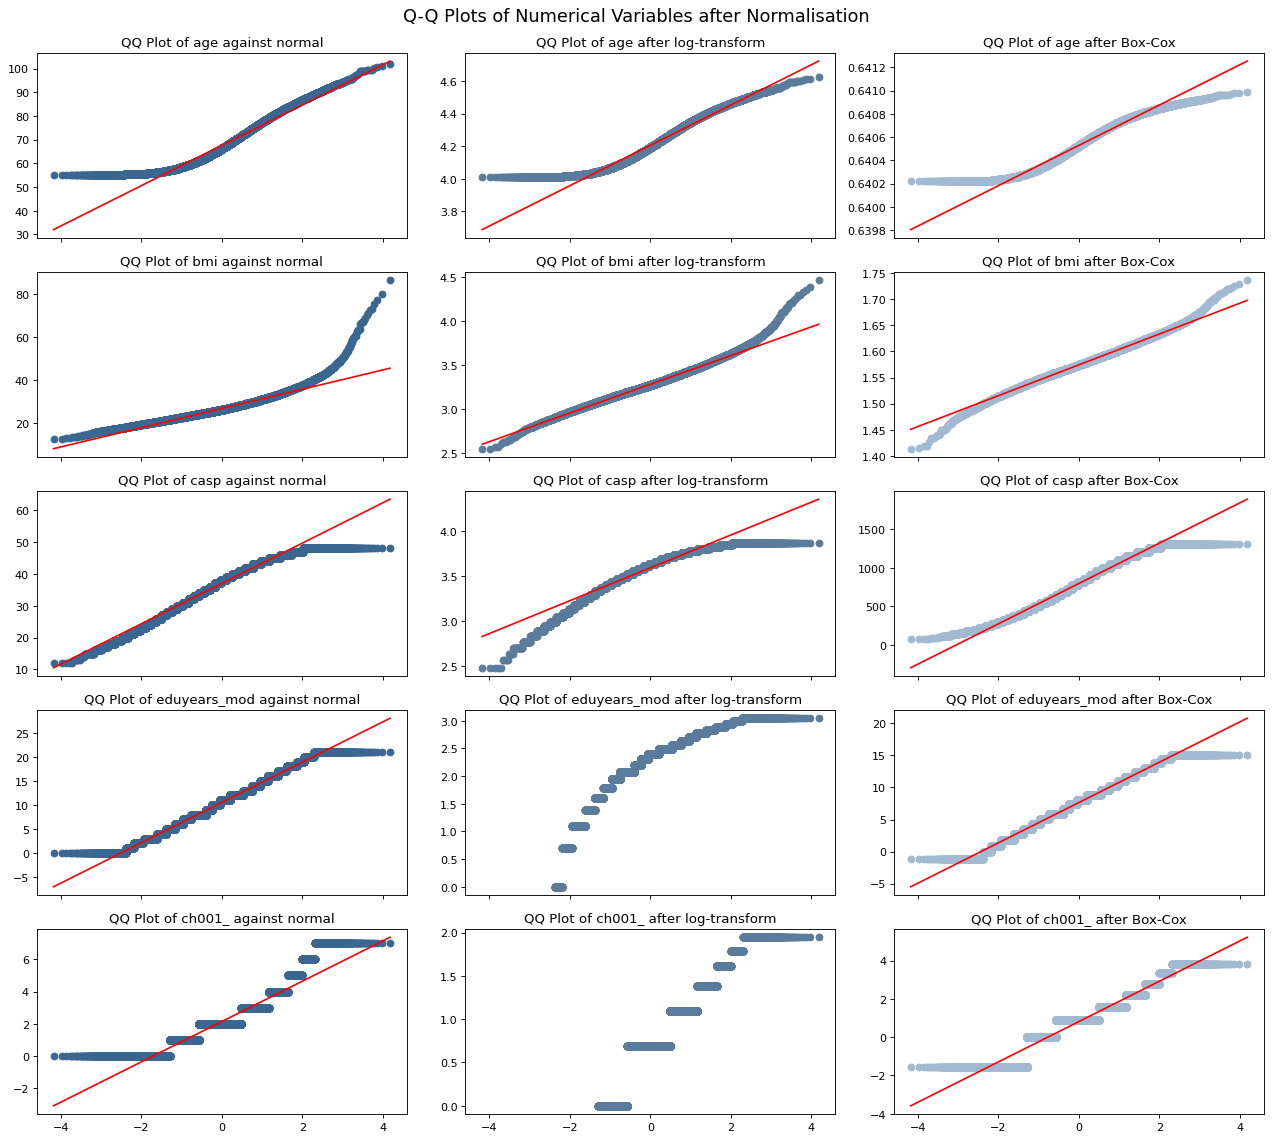

In [12]:
# adapted from Feature Engineering for Machine Learning principles and 
# techniques for data scientists, used from Workshop 1?

# List of variables we applied Box-Cox transformation to
boxcox_list = ['age','bmi','casp','eduyears_mod','ch001_']

# Dataframe with columns we applied Box-Cox transformation to
boxcox_df = df_transformations[boxcox_list]

# List of optimal lambda parameters we obtained
best_lambdas = [bc_age_param, bc_bmi_param, bc_casp_param, bc_eduyrs_param, bc_ch001_param]

# Graph to compare QQ Plots pre and post log-transformation and
# Box-Cox transformation using optimal lambda from prior code chunk
fig2, axs = plt.subplots(5, 3, figsize=(16,14), sharex=True) 

# For loop to create 3 comparison plots for each variable
for i in range(len(axs)):
    # QQ Plot of Original Variable Data
    prob1 = stats.probplot(boxcox_df[boxcox_list[i]].astype(float), dist=stats.norm, 
    plot=axs[i][0])     # Plot original data 
    axs[i][0].set_xlabel('')
    axs[i][0].set_ylabel('') 
    axs[i][0].set_title(f'QQ Plot of {boxcox_list[i]} against normal') 
    axs[i][0].get_lines()[0].set_markerfacecolor('#3a6791')
    axs[i][0].get_lines()[0].set_markeredgecolor('#3a6791')

    # QQ Plot of Log-Transformed Variable Data
    var_logtrans_ = stats.boxcox(boxcox_df[boxcox_list[i]].astype(float), lmbda=0.)
    prob2 = stats.probplot(var_logtrans_, dist=stats.norm, plot=axs[i][1]) 
    axs[i][1].set_xlabel('') 
    axs[i][1].set_ylabel('') 
    axs[i][1].set_title(f'QQ Plot of {boxcox_list[i]} after log-transform')
    axs[i][1].get_lines()[0].set_markerfacecolor('#5a7c9c')
    axs[i][1].get_lines()[0].set_markeredgecolor('#5a7c9c')

    # QQ Plot of Box-Cox Transformed Variable Data
    var_boxcox_ = stats.boxcox(boxcox_df[boxcox_list[i]].astype(float), lmbda=best_lambdas[i])
    prob3 = stats.probplot(var_boxcox_, dist=stats.norm, plot=axs[i][2]) 
    axs[i][2].set_xlabel('') 
    axs[i][2].set_ylabel('') 
    axs[i][2].set_title(f'QQ Plot of {boxcox_list[i]} after Box-Cox')
    axs[i][2].get_lines()[0].set_markerfacecolor('#a1bad1')
    axs[i][2].get_lines()[0].set_markeredgecolor('#a1bad1')

plt.tight_layout()
fig2.suptitle('Q-Q Plots of Numerical Variables after Normalisation', fontsize=16,y=1.015)
plt.show()


From the normalisation of these variables, we can identify that the feature *bmi* has significantly benefitted from the transformation. In general, log-transformation was not beneficial for any of the variables, and for the rest of the numerical features, Box-Cox transformation using their optimal $\lambda$ did not significantly improve the normality (they were visibly close enough to a normal).

Before implementing the last steps of our feature engineering process, we will proceed to explore the correlations matrix of all the observed features.  Taking the correlation between features into consideration is important for numerous reasons. Firstly, it helps reduce colinearity by highlighting which features are highly correlated which would effect the model's accuracy if both were used.  Correlation also allows the ability to idenify which features are highly correlated and hopefully predictive of our desired variable, *cogscore*.

Text(0.5, 0.95, 'Heatmap of Non-ID Variables in easySHARE')

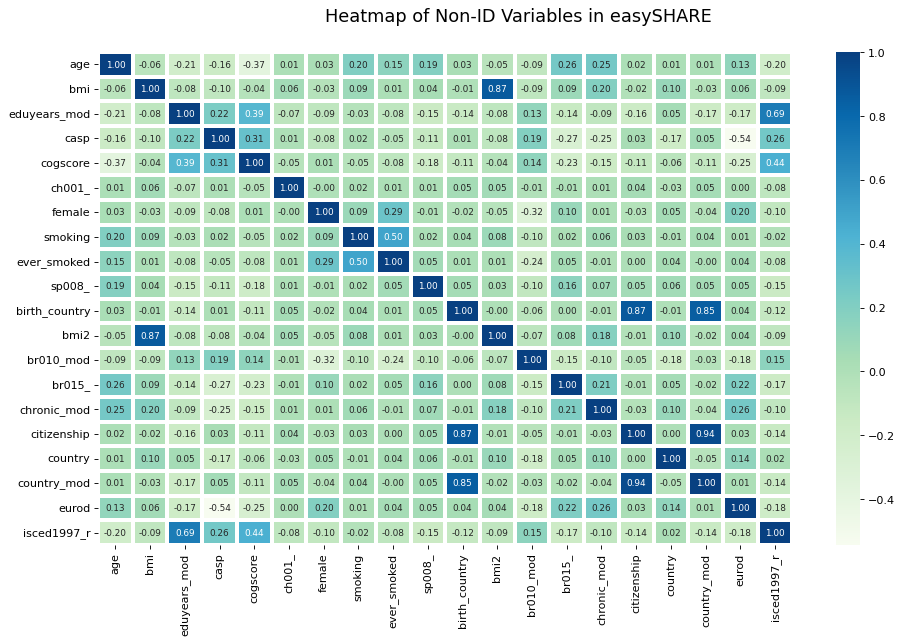

In [13]:
# Plot a heat map to check if any of the features are correlated

rcParams['figure.figsize'] = 14,8
#sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df_transformations[non_id_vars].corr(),cmap="GnBu", annot = True,
            fmt = '.2f',  linewidths = 2, annot_kws={"size": 8})
plt.suptitle('Heatmap of Non-ID Variables in easySHARE',fontsize=16,y=0.95)


As expected, *birth_country*, *country_mod* and *citizenship* have a high positive correlation; as do *eduyears_mod* and *isced1997_r* (ISCED-97 coding of education level), and *bmi* and *bmi2*. This serves as a reminder to choose only one of the representation of demographic factors (continuous vs categorical). Additionally, *eurod* (depression level) and *casp* (quality of life) seem to have medium correlation. Other than this, factors do not seem to have high correlation amongst themselves, thus, it is not evident from the start that any of the other variables could bring collinearity issues to the models. 

Moreover, we can observe that there is some correlation ($\geq$ $\lvert0.2\rvert)$) between our dependent variable of interest, *cogscore*, and the following variables:

- **Education**: *isced1997_r* and *eduyears_mod*
- **Depression**: *eurod*
- **Physical activity**: *br015_*
- **Age**: *age*
- **Quality of life**: *casp*

We will proceed to investigate the scatter plots between *cogscore* and each of these variables in order to identify possible model functional forms.

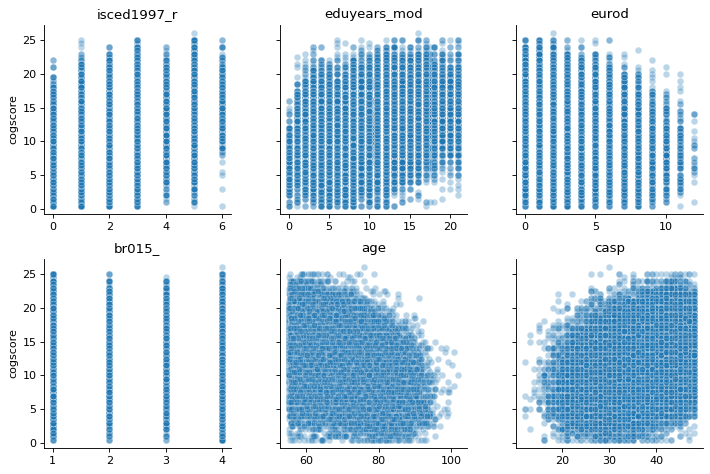

In [14]:
# "Pairplot" equivalent
vars_corr = ['isced1997_r','eduyears_mod','eurod',
                      'br015_','age','casp']
vars_corr_cs = vars_corr + ['cogscore']                      
corr_df = df_transformations[vars_corr_cs]

# Creating Facet Grid
g = sns.FacetGrid(pd.DataFrame(vars_corr), col=0, col_wrap=3, sharex=False)
# Plotting scatterplots
for ax, varx in zip(g.axes, vars_corr):
    sns.scatterplot(data=corr_df, x=varx, y="cogscore", ax=ax,
    alpha=0.3).set_title(varx)
    ax.set_xlabel("")

# plt.suptitle('Scatter Plot of Variables Correlated to Cognitive Score', y=1.02)
# # g.tight_layout()

At first glance, no obvious relationships are apparent functional forms between our possible continuous independent variables and *cogscore*. However, we would expect an indirect relationship between *age* and *cogscore* (as we would expect cognitive score to lower as people age), and a direct relationship between *casp*/*eduyears_mod* and *cogscore* (as it to be expected: on average higher cognitive score for people with higher life quality and education).

Having explored these relationships, we will proceed to do some final data transformations and move on to the modelling stage.

In [15]:
# Data Transformation

# Replacing smoking value 5 (non-smoker) for 0.
for i in binary_vars:
    df_transformations[i] = np.where(df_transformations[i] == 5, 0,df_transformations[i])

bmi2_vals = ['underweight','normal','overweight','obese']
br010_vals = ['no_drink','less1mo_drink','cple1mo_drink','cple1wk_drink',
            '4wk_drink','6wk_drink','daily_drink']
br015_vals = ['more1wk_act','1wk_act','mnthly_act','hardly_act']

df_transformations['bmi2'] = np.where(df_transformations['bmi2'].astype(int)==1,
                        bmi2_vals[0],
                        np.where(df_transformations['bmi2'].astype(int)==2,
                        bmi2_vals[1],
                        np.where(df_transformations['bmi2'].astype(int)==3,
                        bmi2_vals[2],
                        bmi2_vals[3])))

df_transformations['br015_'] = np.where(df_transformations['br015_'].astype(int)==1,
                        br015_vals[0],
                        np.where(df_transformations['br015_'].astype(int)==2,
                        br015_vals[1],
                        np.where(df_transformations['br015_'].astype(int)==3,
                        br015_vals[2],
                        br015_vals[3])))

df_transformations['br010_mod'] = np.where(df_transformations['br010_mod'].astype(int)==1,
                        br010_vals[0],
                        np.where(df_transformations['br010_mod'].astype(int)==2,
                        br010_vals[1],
                        np.where(df_transformations['br010_mod'].astype(int)==3,
                        br010_vals[2],
                        np.where(df_transformations['br010_mod'].astype(int)==4,
                        br010_vals[3],
                        np.where(df_transformations['br010_mod'].astype(int)==5,
                        br010_vals[4],
                        np.where(df_transformations['br010_mod'].astype(int)==6,
                        br010_vals[5],
                        br010_vals[6]))))))

In [16]:

# DATA PARTITIONING

# Set a seed for reproducibility of results
rng = np.random.seed(21701)

# First split off features and targets
# X = df.drop(['mergeid', 'cogscore'], axis = 1) # Set of features
features = ['age','bmi','eduyears_mod','casp','ch001_','female',
            'smoking','ever_smoked','sp008_','bmi2','br010_mod',
            'br015_','chronic_mod','eurod','isced1997_r']

X = df_transformations[features]
y = df_transformations['cogscore']

# We shuffle the data so the countries get mixed up
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

# Do we want to do 80-10-10 to include a validation set? 
# Alternatively, we do CV in the end which may be better
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# print("X_val:", X_val.shape)
# print("y_val:", y_val.shape)

X_train: (38012, 15)
y_train: (38012,)
X_test: (9503, 15)
y_test: (9503,)


# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model, a polynomial regression, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline model(s) on the test data but only briefly describe the baseline model(s) considered*

Following the feature engineering process we are now able to begin the building of our model.  From the data exploration phase we learned which features are highly correlated with eachother, meaning we only need one of them, and which are highly correlated with our depended feature *cogscore*, meaning they definitely should be in the model. Since the scatterplots above did not yield any more information regarding correlation with *cogscore* we will focus on the features that we highlighted from the correlation matrix and were focused on in the literature:
- obesity
- smoking
- education
- drinking behavior
- physical activity level
- quality of life
- age

In [17]:
# Baseline model

# Baseline features
baseline_features = ['eduyears_mod', 'casp','age','eurod','smoking']
X_train_bs, X_test_bs = X_train[baseline_features], X_test[baseline_features]

# Setting up the pipeline for the baseline model
num_pre = Pipeline([
    ("num_scale", StandardScaler())])

baseline_pipe = Pipeline([
    ("pre_processing", ColumnTransformer([("numerical", num_pre, [0,1,2,3]),
                                         ("binary", "passthrough", [4])])),
    ("model", LinearRegression())
])

baseline_model = baseline_pipe.fit(X_train_bs,y_train)

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    baseline_model,
    X_train_bs,
    y_train,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].coef_ * est[:-1].transform(X_train_bs.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X_train_bs, y_train))
    ],
    columns=feature_names,
)

plt.figure(figsize=(16, 4))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance and variability")
plt.title("Baseline linear regression model - CV",fontsize=16)
plt.subplots_adjust(left=0.3)

# Model fit on training data
baseline_MSE, baseline_RMSE, baseline_R2 = model_fit(baseline_model, X_train_bs, y_train, plot = False)
model_fit(baseline_model, X_train_bs, y_train, plot = True)


NameError: name 'feature_names' is not defined

Our baseline model has an R-squared of 28.3% for the training dataset, and as we can see in its plots, this model would not be very reliable to predict the relationship between our independent variables and our dependent variable, *cogscore*. It is important to note, however, that there did not seem to be any evident linear relationship between the dependent and the chosen independent variables. 

Seeking to improve our model performance, we proceeded to use a sequential feature selector (SFS) algorithm to determine which features from the easySHARE database would maximize the performance of our model. This type of algorithm belongs to a family of greedy search algorithms which seek to perform feature demension reduction by identify a subset of most relevant features aiming to enhance computational efficiency and minimize model error. In the case of this study, we chose to perform *forward selection* of features with *mean squared error criteria*, in which the SFS model is initiated with $0$ features and in each iteration of the fitting selects the best single feature that seeks to minimize the mean squared error of the model. Once the minimum has been achieved, no additional features are added to the model and the algorithm terminates with a vector of selected features.

In the case of this study, this algorithm yielded the selection of the following features:

In [ ]:
# Sequential Feature Selection

onehot_encoder = OneHotEncoder(drop='first')

encoder = ColumnTransformer([
    # pass through all columns with numerical values 
    ("num", "passthrough", [0,1,2,3,4,5,6,7,8,12,13,14]), 
    # apply the onehot_encoder to the last column
    ("cat", onehot_encoder, [9,10,11]),
]) 

names_post_encoding = ['age','bmi','eduyears_mod','casp','ch001_','female',
                       'smoking','ever_smoked','sp008_','normal','overweight',
                       'obese','less1mo_drink','cple1mo_drink','cple1wk_drink',
                       '4wk_drink','6wk_drink','daily_drink','1wk_act','mnthly_act',
                       'hardly_act','chronic_mod','eurod','isced1997_r']

X_train_1hot = encoder.fit_transform(X_train)
X_test_1hot = encoder.fit_transform(X_test)

sfs = SequentialFeatureSelector(LinearRegression(),
                                direction='forward',
                                scoring='neg_mean_squared_error')

sfs_selector = sfs.fit(X_train_1hot, y_train)
selected_columns = sfs_selector.get_support()

X_train_best = sfs_selector.transform(X_train_1hot)
X_test_best = sfs_selector.transform(X_test_1hot)

# Columns selected by Sequential Feature Selector
selected_cols_index = (selected_columns*1).tolist()
selected_features = [x for i, x in enumerate(names_post_encoding) if selected_cols_index[i]]
selected_features_df = pd.DataFrame(selected_features,columns=['Selected Features'])
selected_features_df = selected_features_df.style.format('{}')
selected_features_df.set_table_styles([index_names, headers])

,Selected Features
0,age
1,eduyears_mod
2,casp
3,female
4,smoking
5,ever_smoked
6,sp008_
7,overweight
8,obese
9,1wk_act


In line with literature (*Lancet 2017 and 2020*), the SFS algorithm selected indicators of age, education, smoking habits, social contact, obesity, physical activity and other chronic diseases as significant factors to predict dementia severity. Moreover, it selected *casp*, a life quality indicator which in this study's data exploration phase was shown to have a $-0.54$ correlation with depression indicators, thus there is some merit to including only the best predictor of these two variables in the models for dementia severity.
 
The previously listed features were used as the independent variables in the rest of our evaluated models,which include:

- **Polynomial Regression**: This model was used to detect possible non-linear relationships between the factors and dementia severity. A grid search was performed to determine the best fitting polynomial degree, resulting in a second-degree polynomial model. 

- **Ridge Regression**: This model was chosen to contemplate the possibility that some of the features selected could still have coefficients that could be shrinked near to zero, which would allow us to more clearly identify which are the factors that policy-makers must focus on with the highest priority.

- **Elastic Net Regression**: We also evaluated this model with the same goal of the *Ridge Regression*, but taking into consideration it would output some of the coefficients as zero, making the most relevant features even clearer.

- **Random Forest Regression**: Given the Random Forest algorithm's known strength of handling datasets continuous and categorical variables, the present study evaluated training this model seeking to improve prediction accuracy with the algorithm's "wisdom of the crowds" approach.

- **Histogram-Based Gradient Boosting Regression**: In a similar fashion, we choose a histogram-based gradient boosting regression to exploit the *gradient boosting (GB) algorithm* ability to combine the predictive power of multiple weak learners, building sequential simple models to reduce the errors of the previous model. Amongst this type of algorithms, the histogram-based GB is a machine learning technique that "accelerates the training of gradient boosted trees by leveraging histograms and integer-based data structures"<sup>8</sup>, which for our purpose achieves a computationally efficient GB regression.

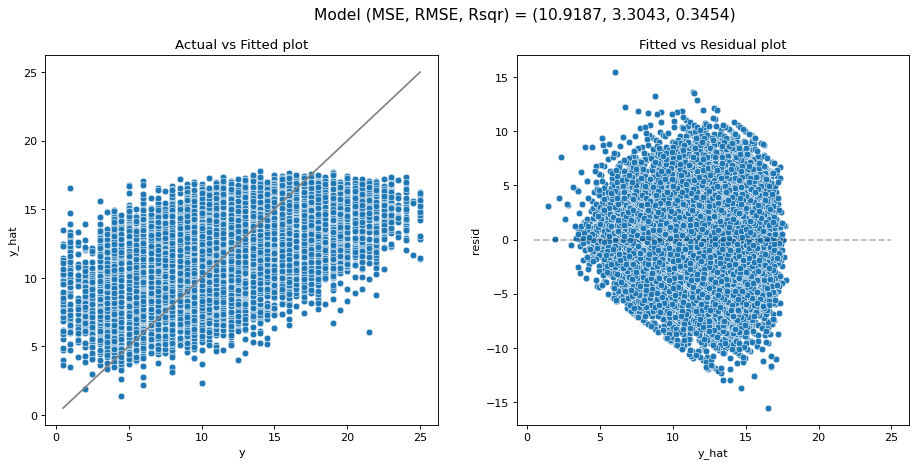

NameError: name 'grid_search' is not defined

In [ ]:
# POLYNOMIAL MODEL AND GRID SEARCH, COOL GRAPH
pf = PolynomialFeatures(include_bias=False)

# Overall ML pipeline
poly_pipe = Pipeline([
    ("poly", pf),
    ("model", LinearRegression())])

# Parameters for grid search
parameters = {
    'poly__degree': np.arange(1, 5, 1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=rng)

# grid_search = GridSearchCV(poly_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train_best, y_train)

# # # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting
# print("best index: ", grid_search.best_index_)
# # Parameter setting that gave the best results on the hold out data
# print("best param: ", grid_search.best_params_)
# # Mean cross-validated score of the best_estimator
# print("best score: ", grid_search.best_score_)

# pd.DataFrame(grid_search.cv_results_)

# degree = np.arange(1, 5, 1)
# fig, ax = plt.subplots(figsize=(9,7), ncols=1, nrows=1)
# plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='k')
# plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='k', label='Mean Train MSE')
# plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='r')
# plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='r', label='CV MSE')
# ax.legend()
# ax.set_xlabel('degree')
# ax.set_ylabel('MSE')
# plt.show()

# it seems like we should stick to degree 2
poly_model = poly_pipe.fit(X_train_best, y_train)

model_fit(poly_model, X_train_best, y_train, plot=True)
# model_fit(poly_model, X_test_best, y_test, plot=True)

# grid_search.fit(X_train_best, y_train)

# print(grid_search.best_params_)
# print(-grid_search.best_score_)

poly_MSE, poly_RMSE, poly_R2 = model_fit(grid_search.best_estimator_, X_test_best, y_test, plot=False)


In [ ]:
# RIDGE MODEL, NOT BEST
# Grid of tuning parameters
alphas = np.linspace(0, 20, num=150)  

#Pipeline
ridge_pipe = make_pipeline(
        StandardScaler(),
        Ridge())

# CV strategy
cv = KFold(5, shuffle=True, random_state=rng)

# Grid search
gs = GridSearchCV(ridge_pipe,
    param_grid={'ridge__alpha': alphas},
    cv=cv,
    scoring="neg_mean_squared_error")

gs.fit(X_train_best, y_train)

# print(gs.best_params_)
# print(-gs.best_score_)

ridge_MSE, ridge_RMSE, ridge_R2 = model_fit(gs.best_estimator_, X_test_best, y_test, plot=False)

{'ridge__alpha': 20.0}
11.111251116743464


In [ ]:
# ELASTIC NET, DOESNT SEEM AS GOOD

alpha_val = np.arange(1, 100, 1)
MSE = []

for alpha in alpha_val:
    r = make_pipeline(
        StandardScaler(),
        ElasticNet(alpha = alpha, random_state=rng)
    ).fit(X_train_best, y_train)

    MSE.append(model_fit(r, X_test_best, y_test)[0])

plt.plot(MSE)
plt.title("MSE for Different Alpha Values in Ridge Regression")
plt.xlabel("Alpha")

print(f"The best value of alpha = {np.argmin(MSE)}")

best_alpha_EN = make_pipeline(
        StandardScaler(),
        ElasticNet(alpha = np.argmin(MSE), random_state=rng)
    ).fit(X_train_best, y_train)

EN_MSE, EN_RMSE, EN_R2 = model_fit(best_alpha_EN, X_test_best, y_test,plot=False)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:1351: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e+05, tolerance: 6.340e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mod

In [ ]:
# RANDOM FOREST, DEFINITELY TRASH

regr = RandomForestRegressor(max_depth=2, random_state=rng)
regr.fit(X_train_best, y_train)

RF_MSE, RF_RMSE, RF_R2 = model_fit(regr, X_train_best, y_train, plot=False)

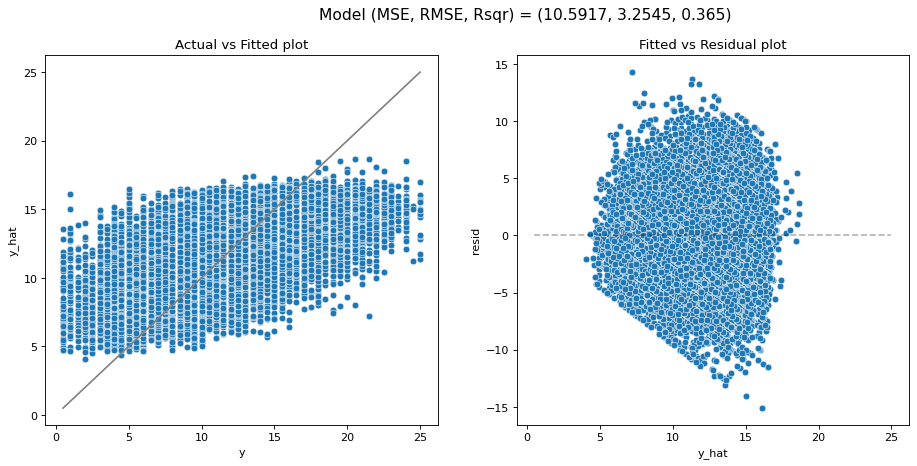

(10.5917, 3.2545, 0.365)

In [ ]:
# GRADIENT BOOSTING, THE ONE <3

gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for feature scaling
    ('hist_gb', HistGradientBoostingRegressor(random_state=rng))  # HistGradientBoostingRegressor for regression
])

gb_reg = gb_pipeline.fit(X_train_best, y_train)

model_fit(gb_reg, X_train_best, y_train, plot=True)
#model_fit(gb_reg, X_test_best, y_test, plot=True)

# Define cross-validation strategy, for example, KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=rng)

# Perform cross-validation and get the R^2 scores (you can change scoring metric)
# cross_val_scores_gb = cross_val_score(gb_reg, X_train_best, y_train, cv=kf, scoring='r2')

# Print the cross-validation scores
# print("Cross-Validation Scores:", cross_val_scores)
# print("Mean R^2 Score:", np.mean(cross_val_scores))

# Define the parameter grid to search
param_grid = {
    'scaler__with_mean': [True, False],  # StandardScaler parameter
    'scaler__with_std': [True, False],   # StandardScaler parameter
    'hist_gb__learning_rate': [0.01, 0.1, 0.2],
    'hist_gb__max_iter': [100, 200, 300],
    'hist_gb__max_depth': [3, 5, 7],
    'hist_gb__min_samples_leaf': [1, 5, 10],
    'hist_gb__max_leaf_nodes': [15, 31, 50],
}

# # PLEASE DONT RUN AGAIN AS IT TAKES FOREVER
# # Perform grid search with cross-validation
# grid_search = GridSearchCV(gb_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
# grid_search.fit(X_train_best, y_train)

# # Print the best parameters and corresponding score
# print("Best Parameters:", grid_search.best_params_)
# print("Best R**2:", grid_search.best_score_)
# # Best Parameters: {'hist_gb__learning_rate': 0.1, 'hist_gb__max_depth': 7, 'hist_gb__max_iter': 100, 'hist_gb__max_leaf_nodes': 15, 'hist_gb__min_samples_leaf': 5, 'scaler__with_mean': True, 'scaler__with_std': True}
# # Best Negative Mean Squared Error: 0.3456750744329497

HGB_MSE, HGB_RMSE, HGB_R2 = model_fit(grid_search.best_estimator_, X_train_best, y_train, plot=False)
model_fit(grid_search.best_estimator_, X_train_best, y_train, plot=True)




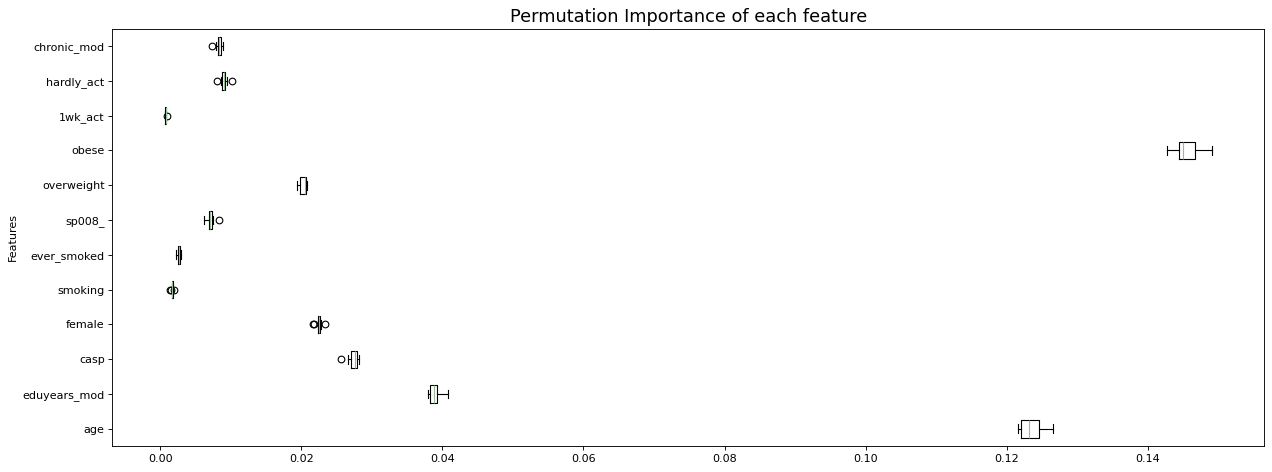

In [ ]:
# rf = grid_search.best_estimator_.fit(X_train_best,y_train)
# result = permutation_importance(rf, X_train_best, y_train, n_repeats=10, random_state=0, n_jobs=-1)

fig, ax = plt.subplots(figsize=(16, 6))
box_plot = ax.boxplot(result.importances.T, vert=False, labels=selected_features)
for median in box_plot['medians']:
    median.set_color('#95bd95')
ax.set_title("Permutation Importance of each feature",fontsize=16)
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

In [ ]:
model_comparison = {'Model': ['Baseline', 'Polynomial', 'Ridge', 'Elastic Net',
                    'Random Forest','Histogram-Based Gradient Boosting'],
                    'MSE': [baseline_MSE,poly_MSE,ridge_MSE,EN_MSE,RF_MSE,HGB_MSE],
                    'RMSE':[baseline_RMSE,poly_RMSE,ridge_RMSE,EN_RMSE,RF_RMSE,HGB_RMSE],
                    'R-Squared':[baseline_R2,poly_R2,ridge_R2,EN_R2,RF_R2,HGB_R2]}  
model_comparison = pd.DataFrame(model_comparison)  
model_comparison=model_comparison.set_index('Model')
model_comp_df = model_comparison.style.format('{}')
model_comp_df.set_table_styles([index_names, headers])

,MSE,RMSE,R-Squared
Model,,,
Baseline,11.9598,3.4583,0.283
Polynomial,10.6257,3.2597,0.3496
Ridge,10.8157,3.2887,0.3379
Elastic Net,10.8157,3.2887,0.3379
Random Forest,12.8146,3.5797,0.2317
Histogram-Based Gradient Boosting,10.5917,3.2545,0.365


# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a government official or charity directy, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on potential lifestyle changes or governmental/societal interventions to reduce dementia risk.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

This project yielded insights on the impacts of an aging population and how we can better predict dementia. Using the easySHARE dataset, the aim of this report was to detect pattern and trends within the data that allow for insights into dementia prediction. Beginning with feature engineering, we used techniques such as normalisation and windsorizing to account for the skewness of the data.  Next, analysis of the correlation matrix between the features provided insights into what features were highly correlated which may cause issues within the model accuracy and what features were highly correlated with cogscore and may be good indicators for dementia. From this, we then selected the first features we would use to create the base model.  Using a linear model, we created a base model which had a 28.3% R-squared value, meaning its predictive power was not strong. Following this baseline model, 5 further regression models were created in order to determine which would provide the optimal result.  

... more discussion


# References

<sup>1</sup> "World Population Prospects 2022, Summary of Results", United Nations, accessed February 29, 2024, *https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/wpp2022_summary_of_results.pdf*.

<sup>2</sup> "Ageing and Health", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/fact-sheets/detail/ageing-and-health#:~:text=Every%20country%20in%20the%20world,in%202020%20to%201.4%20billion.*.

<sup>3</sup> "Dementia", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/facts-in-pictures/detail/dementia*.

<sup>4</sup> "Dementia", World Health Organization, accessed February 29, 2024, *https://www.who.int/news-room/facts-in-pictures/detail/dementia*.

<sup>5</sup> Page 123, Feature Engineering and Selection, 2019, accessed March 5, 2024, *https://shorturl.at/mCKNX*.

<sup>6</sup> "Avoid Mistakes in Machine Learning Models with Skewed Count Data", Medium, accessed March 4, 2024, *https://medium.com/p/e3512b94d745*. 

<sup>7</sup> "Avoid Mistakes in Machine Learning Models with Skewed Count Data", Medium, accessed March 4, 2024, *https://medium.com/p/e3512b94d745*. 

<sup>8</sup> "A Faster Ensemble Model Method in Sklearn: Histogram-Based Gradient Boosting", Medium, accessed March 8, 2024, *https://medium.com/chat-gpt-now-writes-all-my-articles/a-faster-ensemble-model-method-in-sklearn-histogram-based-gradient-boosting-7033ff170bc0*.

"Discussion on handling ordinal categorical vars: https://www3.nd.edu/~rwilliam/stats3/OrdinalIndependent.pdf,\n we do not need to convert with OneHotEncoder unless we are using interaction terms."

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to pdf
/home/codespace/.local/lib/python3.10/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
[NbConvertApp] ERROR | Error while converting 'project1.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
  File "/home/codespace/.local/lib/python3.10/site-packages/nbconvert/exporters/templateexporter.py", line 386, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
  File "/home/codespace/.local/l